In [1]:
pip install lightgbm

     |████████████████████████████████| 2.0 MB 5.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install hail -U

     |████████████████████████████████| 95.0 MB 12 kB/s  eta 0:00:01
     |████████████████████████████████| 108 kB 91.1 MB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 89.0 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 81.7 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 86.6 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 90.7 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 85.4 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 6.1 MB/s  eta 0:00:01
     |████████████████████████████████| 79 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 5.6 MB/s  eta 0:00:01
  Created wheel for avro: filename=avro-1.10.2-py3-none-any.whl size=96830 sha256=d5d140607046fb631b0f54f0106

In [3]:
pip install shap

     |████████████████████████████████| 371 kB 5.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 40 kB 8.5 MB/s  eta 0:00:01
  Created wheel for shap: filename=shap-0.40.0-cp38-cp38-linux_x86_64.whl size=558689 sha256=fbe206c3d504a2827987acb2fd4c0abb779facd64444d6e13534862206d8fcc9
  Stored in directory: /root/.cache/pip/wheels/77/07/6b/ff54f2fdec86581ea5f6131ec0fd424bef58841d6684035114
Successfully built shap
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
Note: you may need to restart the kernel to use updated packages.


In [4]:
#import libraries:

import pandas as pd
import numpy as np
import time
import re
from matplotlib import pyplot
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

import shap
import warnings

import hail as hl
hl.init()

from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
output_notebook()

seed = 42

Running on Apache Spark version 3.1.1
SparkUI available at http://annotation-cluster-m.c.neale-ukb-sumstats.internal:46469
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.78-b17627756568
LOGGING: writing to /home/hail/hail-20211118-1023-0.2.78-b17627756568.log


Loading BokehJS ...

In [5]:
ht = hl.import_matrix_table('gs://bucket-hnicholls/test/Evangelou_GWAS.txt',
                            row_fields={'Chr': hl.tstr, 'Start': hl.tint32, 'End': hl.tint32, 'Ref': hl.tstr,
                                         'Alt': hl.tstr, 'CP': hl.tstr,'BETAsbp': hl.tfloat64, 
                                         'BETAdbp': hl.tfloat64, 'BETApp': hl.tfloat64,
                                        'minP': hl.tfloat64, 'BETAmean': hl.tfloat64, 'minTRAIT': hl.tstr,
                                       'Gene': hl.tstr, 'Type': hl.tstr, 'Source': hl.tstr, 'CLNDN': hl.tstr}, 
                            min_partitions=100)               

In [6]:
ht = ht.key_rows_by(locus=hl.locus(ht.Chr, ht.Start, reference_genome='GRCh37'), alleles=[ht.Ref, ht.Alt])

In [7]:
cadd_ht = hl.experimental.load_dataset(name='CADD',
                                       reference_genome='GRCh37',
                                       version='1.6',
                                       region='us',
                                       cloud='gcp')

In [8]:
db = hl.experimental.DB(region='us', cloud='gcp')
mt = db.annotate_rows_db(ht, 'DANN', 'gerp_scores', 'dbNSFP_variants',
                         'gnomad_annotation_pext')

In [9]:
mt = mt.annotate_rows(CADD = cadd_ht.index(mt.row_key))

In [10]:
#hl.import_vcf('gs://bucket-hnicholls/test/clinvar.vcf').write('gs://bucket-hnicholls/test/clinvar.mt', overwrite=True)

In [11]:
mt_clinvar = hl.read_matrix_table('gs://bucket-hnicholls/test/clinvar.mt')

In [12]:
ht_clinvar = mt_clinvar.make_table()

In [13]:
ht_clinvar = ht_clinvar.annotate(MedGen = ht_clinvar.info.CLNDISDB,
                                diagnosis = ht_clinvar.info.CLNDN,
                                star = ht_clinvar.info.CLNREVSTAT,
                                pathogenicity = ht_clinvar.info.CLNSIG)

ht_clinvar = ht_clinvar.select(ht_clinvar.MedGen, ht_clinvar.diagnosis, ht_clinvar.star, ht_clinvar.pathogenicity)

In [14]:
ht = mt.make_table() 

In [15]:
ht = ht.key_by('locus').join(ht_clinvar.key_by('locus'), how='left')


2021-11-18 10:24:14 Hail: INFO: Table.join: renamed the following fields on the right to avoid name conflicts:
    'locus' -> 'locus_1'
    'alleles' -> 'alleles_1'


In [16]:
ht = ht.annotate(
    clinvar_criteria = hl.zip(ht.pathogenicity, 
                              ht.star, 
                              fill_missing=True))

In [17]:
set_of_medgen = {True, True}

ht_labeled = ht.annotate(pathogenic_clinvar = ht.clinvar_criteria.filter(lambda x: hl.literal(set_of_medgen).contains(
                          (x[0].lower().contains('pathogen') |  (x[0] == 'Pathogenic') | (x[0] == 'Likely_pathogenic')) &
                          (x[1] == "criteria_provided") |
                          (x[1] == "criteria_provided_single_submitter") | 
                          (x[1] == "criteria_provided_multiple_submitters_no_conflicts") |
                          (x[1] == 'reviewed_by_expert_panel') | (x[1] == "practice_guideline"))))

ht_labeled = ht_labeled.annotate(label = ht_labeled.pathogenic_clinvar.any(lambda x: hl.is_defined(x)))

In [19]:
ht_labeled.filter(ht_labeled.label).count()

2021-11-08 13:11:14 Hail: INFO: Coerced sorted dataset


17

In [19]:
ht_labeled = ht_labeled.repartition(1000)

In [31]:
ht_labeled = ht_labeled.checkpoint('gs://bucket-hnicholls/test/ht_labeled_checkpoint1.ht', overwrite=True)

2021-11-18 12:37:07 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 12:37:31 Hail: INFO: Coerced sorted dataset
2021-11-18 12:42:27 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:17:48 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:17:51 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:17:53 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:17:54 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:17:56 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:17:58 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:18:00 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:18:02 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:18:04 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 13:18:06 Hail: INFO: Ordering unsorted dataset with network shuff

In [32]:
ht_labeled = ht_labeled.annotate(REVEL = hl.if_else(hl.is_defined(ht_labeled.dbNSFP_variants.REVEL_rankscore),
                                                    hl.sum(ht_labeled.dbNSFP_variants.REVEL_rankscore), 0),
                                 
                                 MVP = hl.if_else(hl.is_defined(ht_labeled.dbNSFP_variants.MVP_rankscore),
                                                  hl.sum(ht_labeled.dbNSFP_variants.MVP_rankscore), 0),
                                                        
                                 GenoCanyon = hl.if_else(hl.is_defined(ht_labeled.dbNSFP_variants.GenoCanyon_rankscore),
                                                         hl.sum(ht_labeled.dbNSFP_variants.GenoCanyon_rankscore), 0),
                                                    
                                 DEOGEN2 = hl.if_else(hl.is_defined(ht_labeled.dbNSFP_variants.DEOGEN2_rankscore),
                                                      hl.sum(ht_labeled.dbNSFP_variants.DEOGEN2_rankscore), 0),
                                                           
                                 integrated_fitCons = hl.if_else(hl.is_defined(ht_labeled.dbNSFP_variants.integrated_fitCons_rankscore),
                                                                 hl.sum(ht_labeled.dbNSFP_variants.integrated_fitCons_rankscore), 0),
                                                            
                                 LINSIGHT = hl.if_else(hl.is_defined(ht_labeled.dbNSFP_variants.LINSIGHT_rankscore),
                                                       hl.sum(ht_labeled.dbNSFP_variants.LINSIGHT_rankscore), 0),
                                                        
                                 SiPhy_29way_logOdds = hl.if_else(hl.is_defined(ht_labeled.dbNSFP_variants.SiPhy_29way_logOdds_rankscore),
                                                                  hl.sum(ht_labeled.dbNSFP_variants.SiPhy_29way_logOdds_rankscore), 0),
                                                         
                                 bStatistic = hl.if_else(hl.is_defined(ht_labeled.dbNSFP_variants.bStatistic_rankscore),
                                                               hl.sum(ht_labeled.dbNSFP_variants.bStatistic_rankscore), 0),
                                 
                                 GTEx_mean_proportion = hl.if_else(hl.is_defined(ht_labeled.gnomad_annotation_pext.tx_annotation.mean_proportion),
                                                               hl.sum(ht_labeled.gnomad_annotation_pext.tx_annotation.mean_proportion), 0),
                                 
                                 sift_score = hl.if_else(hl.is_defined(ht_labeled.gnomad_annotation_pext.vep.transcript_consequences.sift_score),
                                                               hl.sum(ht_labeled.gnomad_annotation_pext.vep.transcript_consequences.sift_score), 0),
                                 
                                 polyphen_score = hl.if_else(hl.is_defined(ht_labeled.gnomad_annotation_pext.vep.transcript_consequences.polyphen_score),
                                                               hl.sum(ht_labeled.gnomad_annotation_pext.vep.transcript_consequences.polyphen_score), 0),
                                 
                                 motif_score_change = hl.if_else(hl.is_defined(ht_labeled.gnomad_annotation_pext.vep.motif_feature_consequences.motif_score_change),
                                                               hl.sum(ht_labeled.gnomad_annotation_pext.vep.motif_feature_consequences.motif_score_change), 0),
                                 
                                                          )

In [33]:
ht_encode_loci = ht_labeled.annotate(chr = ht_labeled.locus.contig,
                                position = ht_labeled.locus.position)
ht_encode_loci = ht_encode_loci.select(ht_encode_loci.chr, ht_encode_loci.position)

In [34]:
H3k9ac_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k9acStdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k9ac_ht = H3k9ac_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k9ac_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H3k4me1_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k4me1StdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k4me1_ht = H3k4me1_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k4me1_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H3k4me3_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k4me3StdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k4me3_ht = H3k4me3_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k4me3_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H4k20me1_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H4k20me1StdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H4k20me1_ht = H4k20me1_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H4k20me1_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H3k9me3_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k9me3StdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k9me3_ht = H3k9me3_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k9me3_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H3k79me2_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k79me2StdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k79me2_ht = H3k79me2_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k79me2_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H3k36me3_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k36me3StdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k36me3_ht = H3k36me3_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k36me3_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H3k27me3_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k27me3StdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k27me3_ht = H3k27me3_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k27me3_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H3k27ac_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k27acStdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k27ac_ht = H3k27ac_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k27ac_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

H3k4me2_ht = hl.import_table("gs://bucket-hnicholls/test/wgEncodeBroadHistoneGm12878H3k4me2StdPk.txt",
                         impute=True, min_partitions=100, no_header=True)
H3k4me2_ht = H3k4me2_ht.rename({'f1' : 'chr', 'f2' : 'Start', 'f3' : 'End', 'f7' : 'H3k4me2_signalValue',
                              'f8' : 'pValue' ,'f9' : 'qValue'})

2021-11-18 14:16:29 Hail: INFO: Reading table to impute column types
2021-11-18 14:16:31 Hail: INFO: Finished type imputation
  Loading field 'f0' as type int32 (imputed)
  Loading field 'f1' as type str (imputed)
  Loading field 'f2' as type int32 (imputed)
  Loading field 'f3' as type int32 (imputed)
  Loading field 'f4' as type str (imputed)
  Loading field 'f5' as type int32 (imputed)
  Loading field 'f6' as type str (imputed)
  Loading field 'f7' as type float64 (imputed)
  Loading field 'f8' as type float64 (imputed)
  Loading field 'f9' as type int32 (imputed)
2021-11-18 14:16:32 Hail: INFO: Reading table to impute column types
2021-11-18 14:16:33 Hail: INFO: Finished type imputation
  Loading field 'f0' as type int32 (imputed)
  Loading field 'f1' as type str (imputed)
  Loading field 'f2' as type int32 (imputed)
  Loading field 'f3' as type int32 (imputed)
  Loading field 'f4' as type str (imputed)
  Loading field 'f5' as type int32 (imputed)
  Loading field 'f6' as type str (

In [35]:
H3k9ac_ht = H3k9ac_ht.annotate(chr = H3k9ac_ht.chr.replace('chr', ''))
H3k4me1_ht = H3k4me1_ht.annotate(chr = H3k4me1_ht.chr.replace('chr', ''))
H3k4me2_ht = H3k4me2_ht.annotate(chr = H3k4me2_ht.chr.replace('chr', ''))
H3k4me3_ht = H3k4me3_ht.annotate(chr = H3k4me3_ht.chr.replace('chr', ''))
H4k20me1_ht = H4k20me1_ht.annotate(chr = H4k20me1_ht.chr.replace('chr', ''))
H4k20me1_ht = H4k20me1_ht.filter(H4k20me1_ht.Start != 0)
H3k9me3_ht = H3k9me3_ht.annotate(chr = H3k9me3_ht.chr.replace('chr', ''))
H3k79me2_ht = H3k79me2_ht.annotate(chr = H3k79me2_ht.chr.replace('chr', ''))
H3k36me3_ht = H3k36me3_ht.annotate(chr = H3k36me3_ht.chr.replace('chr', ''))
H3k27me3_ht = H3k27me3_ht.annotate(chr = H3k27me3_ht.chr.replace('chr', ''))
H3k27ac_ht = H3k27ac_ht.annotate(chr = H3k27ac_ht.chr.replace('chr', ''))

H3k9ac_ht = H3k9ac_ht.annotate(interval=hl.locus_interval(H3k9ac_ht.chr, H3k9ac_ht.Start, H3k9ac_ht.End, reference_genome='GRCh37')).key_by('interval')
H3k9ac_ht = H3k9ac_ht.select(H3k9ac_ht.H3k9ac_signalValue)

H3k4me1_ht = H3k4me1_ht.annotate(interval=hl.locus_interval(H3k4me1_ht.chr, H3k4me1_ht.Start, H3k4me1_ht.End, reference_genome='GRCh37')).key_by('interval')
H3k4me1_ht = H3k4me1_ht.select(H3k4me1_ht.H3k4me1_signalValue)

H3k4me2_ht = H3k4me2_ht.annotate(interval=hl.locus_interval(H3k4me2_ht.chr, H3k4me2_ht.Start, H3k4me2_ht.End, reference_genome='GRCh37')).key_by('interval')
H3k4me2_ht = H3k4me2_ht.select(H3k4me2_ht.H3k4me2_signalValue)

H3k4me3_ht = H3k4me3_ht.annotate(interval=hl.locus_interval(H3k4me3_ht.chr, H3k4me3_ht.Start, H3k4me3_ht.End, reference_genome='GRCh37')).key_by('interval')
H3k4me3_ht = H3k4me3_ht.select(H3k4me3_ht.H3k4me3_signalValue)

H4k20me1_ht = H4k20me1_ht.annotate(interval=hl.locus_interval(H4k20me1_ht.chr, H4k20me1_ht.Start, H4k20me1_ht.End, reference_genome='GRCh37')).key_by('interval')
H4k20me1_ht = H4k20me1_ht.select(H4k20me1_ht.H4k20me1_signalValue)

H3k79me2_ht = H3k79me2_ht.annotate(interval=hl.locus_interval(H3k79me2_ht.chr, H3k79me2_ht.Start, H3k79me2_ht.End)).key_by('interval')
H3k79me2_ht = H3k79me2_ht.select(H3k79me2_ht.H3k79me2_signalValue)

H3k27me3_ht = H3k27me3_ht.annotate(interval=hl.locus_interval(H3k27me3_ht.chr, H3k27me3_ht.Start, H3k27me3_ht.End)).key_by('interval')
H3k27me3_ht = H3k27me3_ht.select(H3k27me3_ht.H3k27me3_signalValue)

H3k27ac_ht = H3k27ac_ht.annotate(interval=hl.locus_interval(H3k27ac_ht.chr, H3k27ac_ht.Start, H3k27ac_ht.End)).key_by('interval')
H3k27ac_ht = H3k27ac_ht.select(H3k27ac_ht.H3k27ac_signalValue)

H3k36me3_ht = H3k36me3_ht.annotate(interval=hl.locus_interval(H3k36me3_ht.chr, H3k36me3_ht.Start, H3k36me3_ht.End)).key_by('interval')
H3k36me3_ht = H3k36me3_ht.select(H3k36me3_ht.H3k36me3_signalValue)

H3k9me3_ht = H3k9me3_ht.annotate(interval=hl.locus_interval(H3k9me3_ht.chr, H3k9me3_ht.Start, H3k9me3_ht.End)).key_by('interval')
H3k9me3_ht = H3k9me3_ht.select(H3k9me3_ht.H3k9me3_signalValue)


In [36]:
ht_labeled = ht_labeled.annotate(**H3k9ac_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H3k4me1_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H3k4me2_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H3k4me3_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H4k20me1_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H3k79me2_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H3k27me3_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H3k27ac_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H3k36me3_ht[ht_labeled.locus])
ht_labeled = ht_labeled.annotate(**H3k9me3_ht[ht_labeled.locus])

In [37]:
ht_labeled = ht_labeled.annotate(H3k9ac_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k9ac_signalValue),
                                                    ht_labeled.H3k9ac_signalValue, 0),
                                 
                                 H3k4me1_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k4me1_signalValue),
                                                    ht_labeled.H3k4me1_signalValue, 0),
                                 
                                 H3k4me2_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k4me2_signalValue),
                                                    ht_labeled.H3k4me2_signalValue, 0),
                                   
                                 H3k4me3_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k4me3_signalValue),
                                                    ht_labeled.H3k4me3_signalValue, 0),
                                 
                                 H4k20me1_signalValue = hl.if_else(hl.is_defined(ht_labeled.H4k20me1_signalValue),
                                                    ht_labeled.H4k20me1_signalValue, 0),
                                 
                                 H3k9me3_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k9me3_signalValue),
                                                    ht_labeled.H3k9me3_signalValue, 0),
                                 
                                 H3k79me2_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k79me2_signalValue),
                                                    ht_labeled.H3k79me2_signalValue, 0),
                                 
                                 H3k36me3_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k36me3_signalValue),
                                                    ht_labeled.H3k36me3_signalValue, 0),
                                 
                                 H3k27me3_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k27me3_signalValue),
                                                    ht_labeled.H3k27me3_signalValue, 0),
                                 
                                 H3k27ac_signalValue = hl.if_else(hl.is_defined(ht_labeled.H3k27ac_signalValue),
                                                    ht_labeled.H3k27ac_signalValue, 0)
                                )

In [38]:
ht_labeled = ht_labeled.annotate(motif_impact = hl.if_else(hl.is_defined(ht_labeled.gnomad_annotation_pext.vep.motif_feature_consequences.impact), 
                                   1, 0),
                                intergenic_impact = hl.if_else(hl.is_defined(ht_labeled.gnomad_annotation_pext.vep.intergenic_consequences.impact), 
                                   1, 0),
                                regulatory_impact = hl.if_else(hl.is_defined(ht_labeled.gnomad_annotation_pext.vep.regulatory_feature_consequences.impact), 
                                   1, 0),
                                transcript_impact = hl.if_else(hl.is_defined(ht_labeled.gnomad_annotation_pext.vep.transcript_consequences.impact), 
                                   1, 0),
                                lof_HC = hl.if_else(ht_labeled.gnomad_annotation_pext.vep.transcript_consequences.lof.any(lambda x: x == 'HC'), 
                                   1, 0),
                                polyphen_pred = hl.if_else(ht_labeled.gnomad_annotation_pext.vep.transcript_consequences.polyphen_prediction.any(lambda x: x.contains('damaging')), 
                                   1, 0),
                                sift_pred = hl.if_else(ht_labeled.gnomad_annotation_pext.vep.transcript_consequences.sift_prediction.any(lambda x: x.contains('deleterious')), 
                                   1, 0))

In [39]:
ht_labeled = ht_labeled.checkpoint('gs://bucket-hnicholls/test/ht_labeled_checkpoint2.ht', overwrite=True)

2021-11-18 14:16:48 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:49 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:49 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:50 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:50 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:51 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:52 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:53 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:54 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:16:54 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-11-18 14:17:18 Hail: INFO: wrote table with 47281 rows in 1000 partitions to gs://bucket-hnicholls/test/ht_labeled_checkpoint2.ht
    Total size: 10.42 MiB
    * Rows: 10.42 MiB
    * Globals: 11.00 B
    

In [41]:
ht_labeled.n_partitions()

1000

In [40]:
ht_labeled.export('gs://bucket-hnicholls/test/BP_GWAS_Annotated.tsv.bgz')

2021-11-18 14:17:25 Hail: INFO: merging 1000 files totalling 13.3M...
2021-11-18 14:17:27 Hail: INFO: while writing:
    gs://bucket-hnicholls/test/BP_GWAS_Annotated.tsv.bgz
  merge time: 2.798s


## Genome Coverage Calculation Per Feature

In [42]:
ht_labeled = ht_labeled.annotate(CADD_phred = ht_labeled.CADD.PHRED_score,
                                             CADD_raw = ht_labeled.CADD.PHRED_score,
                                             DANN_score = ht_labeled.DANN.score,
                                             gerp_scoresN = ht_labeled.gerp_scores.N,
                                             gerp_scoresS = ht_labeled.gerp_scores.S)


FEATURES = [
    'BETAdbp', 
    'BETAsbp',
    'BETApp',
    'minP',
    'polyphen_score',
    'sift_score', 
    'motif_score_change',
    'GTEx_mean_proportion',
    'REVEL',
    'MVP',
    'GenoCanyon',
    'DEOGEN2', 
    'integrated_fitCons',
    'LINSIGHT', 
    'SiPhy_29way_logOdds',
    'bStatistic',
    'motif_impact', 
    'intergenic_impact',
    'regulatory_impact', 
    'transcript_impact',
    'lof_HC',
    'polyphen_pred',
    'sift_pred', 
    'CADD_phred',
    'CADD_raw',
    'gerp_scoresN',
    'gerp_scoresS',
    'DANN_score',
    'H3k9ac_signalValue', 
    'H3k4me1_signalValue', 
    'H3k4me2_signalValue',
    'H3k4me3_signalValue', 
    'H4k20me1_signalValue',
    'H3k79me2_signalValue',
    'H3k27me3_signalValue', 
    'H3k27ac_signalValue', 
    'H3k36me3_signalValue',
    'H3k9me3_signalValue'
]

In [43]:
feature_coverage = ht_labeled.aggregate(
    hl.struct(**{feature: hl.agg.fraction(ht_labeled[feature] > 0) for feature in FEATURES}))

In [44]:
feature_coverage

Struct(BETAdbp=0.40104904718597323, BETAsbp=0.39876483153909603, BETApp=0.3980880269029843, minP=0.7956684503288848, polyphen_score=0.002432266661026628, sift_score=0.0036166747742222036, motif_score_change=0.0002115014487849242, GTEx_mean_proportion=0.008163955923098072, REVEL=0.0037858759332501427, MVP=0.00016920115902793934, GenoCanyon=0.0039762272371565745, DEOGEN2=0.003447473615194264, integrated_fitCons=0.0039762272371565745, LINSIGHT=0.0001269008692709545, SiPhy_29way_logOdds=0.003955077092278082, bStatistic=0.0039762272371565745, motif_impact=0.0007402550707472347, intergenic_impact=0.0, regulatory_impact=0.08286626763393329, transcript_impact=0.46077705632283583, lof_HC=6.345043463547725e-05, polyphen_pred=0.0006979547809902498, sift_pred=0.0008671559400181891, CADD_phred=0.582982593430765, CADD_raw=0.582982593430765, gerp_scoresN=0.9099638332522578, gerp_scoresS=0.455933673145661, DANN_score=0.46077705632283583, H3k9ac_signalValue=0.08834415515746283, H3k4me1_signalValue=0.17

<BarContainer object of 38 artists>

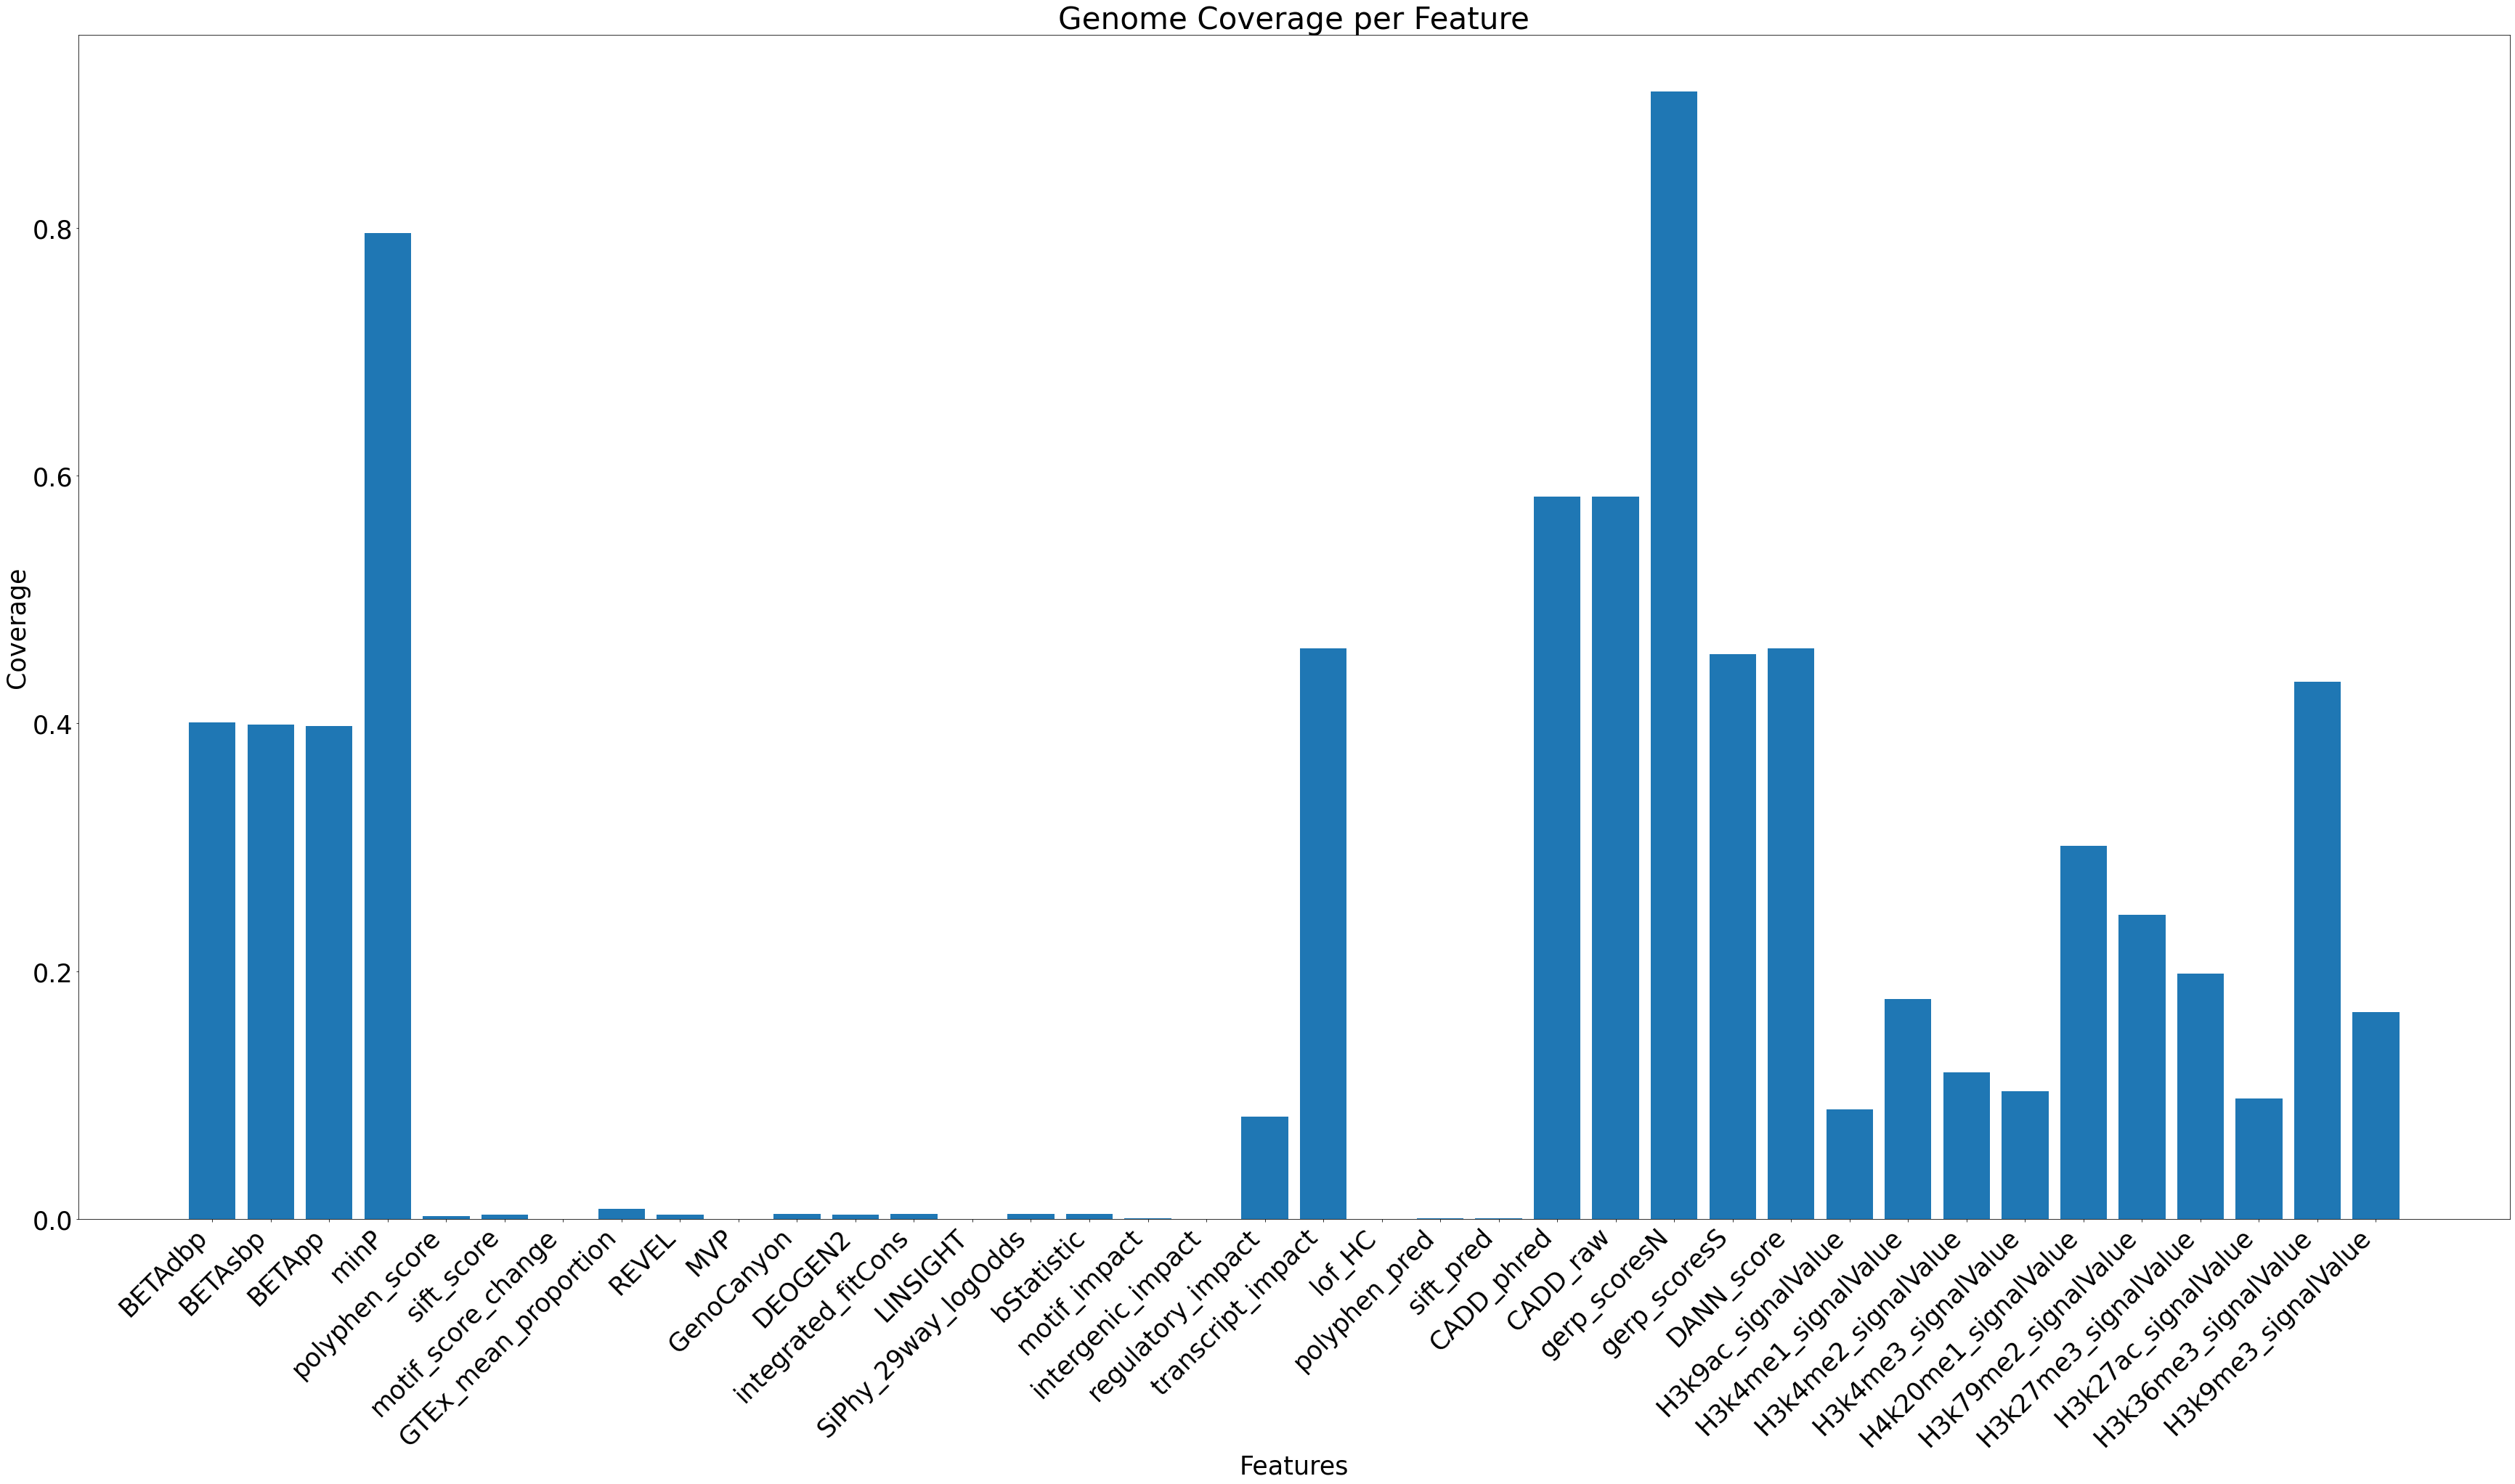

In [45]:
keys = feature_coverage.keys()
values = feature_coverage.values()
pyplot.rcParams["figure.figsize"] = (60,30)
pyplot.rcParams.update({'font.size': 35})
pyplot.xticks(rotation=45, ha="right")
pyplot.title("Genome Coverage per Feature")
pyplot.xlabel("Features")
pyplot.ylabel("Coverage")
pyplot.bar(keys, values)

## Machine Learning

In [46]:
table_result = ht_labeled.select(ht_labeled.Gene, ht_labeled.CP, ht_labeled.diagnosis, ht_labeled.star, ht_labeled.pathogenicity, ht_labeled.DANN, ht_labeled.CADD, ht_labeled.gerp_scores,
                                 ht_labeled.BETAsbp,
                                 ht_labeled.BETAdbp,
                                 ht_labeled.BETApp,
                                 ht_labeled.minP,
                                 ht_labeled.motif_impact,
                                 ht_labeled.intergenic_impact, 
                                 ht_labeled.regulatory_impact, 
                                 ht_labeled.transcript_impact, 
                                 ht_labeled.lof_HC, 
                                 ht_labeled.polyphen_pred, 
                                 ht_labeled.sift_pred,
                                 ht_labeled.polyphen_score, 
                                 ht_labeled.sift_score,
                                 ht_labeled.motif_score_change,
                                 ht_labeled.GTEx_mean_proportion,
                                 ht_labeled.REVEL,
                                 ht_labeled.MVP,
                                 ht_labeled.GenoCanyon,
                                 ht_labeled.DEOGEN2,
                                 ht_labeled.integrated_fitCons,
                                 ht_labeled.LINSIGHT,
                                 ht_labeled.SiPhy_29way_logOdds,
                                 ht_labeled.bStatistic,
                                 ht_labeled.H3k9ac_signalValue, 
                                 ht_labeled.H3k4me1_signalValue, 
                                 ht_labeled.H3k4me2_signalValue,
                                 ht_labeled.H3k4me3_signalValue, 
                                 ht_labeled.H4k20me1_signalValue,
                                 ht_labeled.H3k79me2_signalValue,
                                 ht_labeled.H3k27me3_signalValue, 
                                 ht_labeled.H3k27ac_signalValue, 
                                 ht_labeled.H3k36me3_signalValue,
                                 ht_labeled.H3k9me3_signalValue,
                                 ht_labeled.label)

In [47]:
pd_table = table_result.to_pandas()

In [ ]:
#pd_table.to_csv('BP_GWAS_Annotated.csv', header=True)

In [49]:
features = pd_table[['DANN.score',
 'CADD.raw_score',
 'CADD.PHRED_score',
 'gerp_scores.N',
 #'gerp_scores.S',
 'BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
 'motif_impact',
 'intergenic_impact',
 'regulatory_impact',
 'transcript_impact',
 'lof_HC',
 'polyphen_pred',
 'sift_pred',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'GTEx_mean_proportion',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',
                    'H3k9ac_signalValue', 
    'H3k4me1_signalValue', 
    'H3k4me2_signalValue',
    'H3k4me3_signalValue', 
    'H4k20me1_signalValue',
    'H3k79me2_signalValue',
    'H3k27me3_signalValue', 
    'H3k27ac_signalValue', 
    'H3k36me3_signalValue',
    'H3k9me3_signalValue']]

array([[<AxesSubplot:title={'center':'DANN.score'}>,
        <AxesSubplot:title={'center':'CADD.raw_score'}>,
        <AxesSubplot:title={'center':'CADD.PHRED_score'}>,
        <AxesSubplot:title={'center':'gerp_scores.N'}>,
        <AxesSubplot:title={'center':'BETAsbp'}>,
        <AxesSubplot:title={'center':'BETAdbp'}>],
       [<AxesSubplot:title={'center':'BETApp'}>,
        <AxesSubplot:title={'center':'minP'}>,
        <AxesSubplot:title={'center':'motif_impact'}>,
        <AxesSubplot:title={'center':'intergenic_impact'}>,
        <AxesSubplot:title={'center':'regulatory_impact'}>,
        <AxesSubplot:title={'center':'transcript_impact'}>],
       [<AxesSubplot:title={'center':'lof_HC'}>,
        <AxesSubplot:title={'center':'polyphen_pred'}>,
        <AxesSubplot:title={'center':'sift_pred'}>,
        <AxesSubplot:title={'center':'polyphen_score'}>,
        <AxesSubplot:title={'center':'sift_score'}>,
        <AxesSubplot:title={'center':'motif_score_change'}>],
       [<Axes

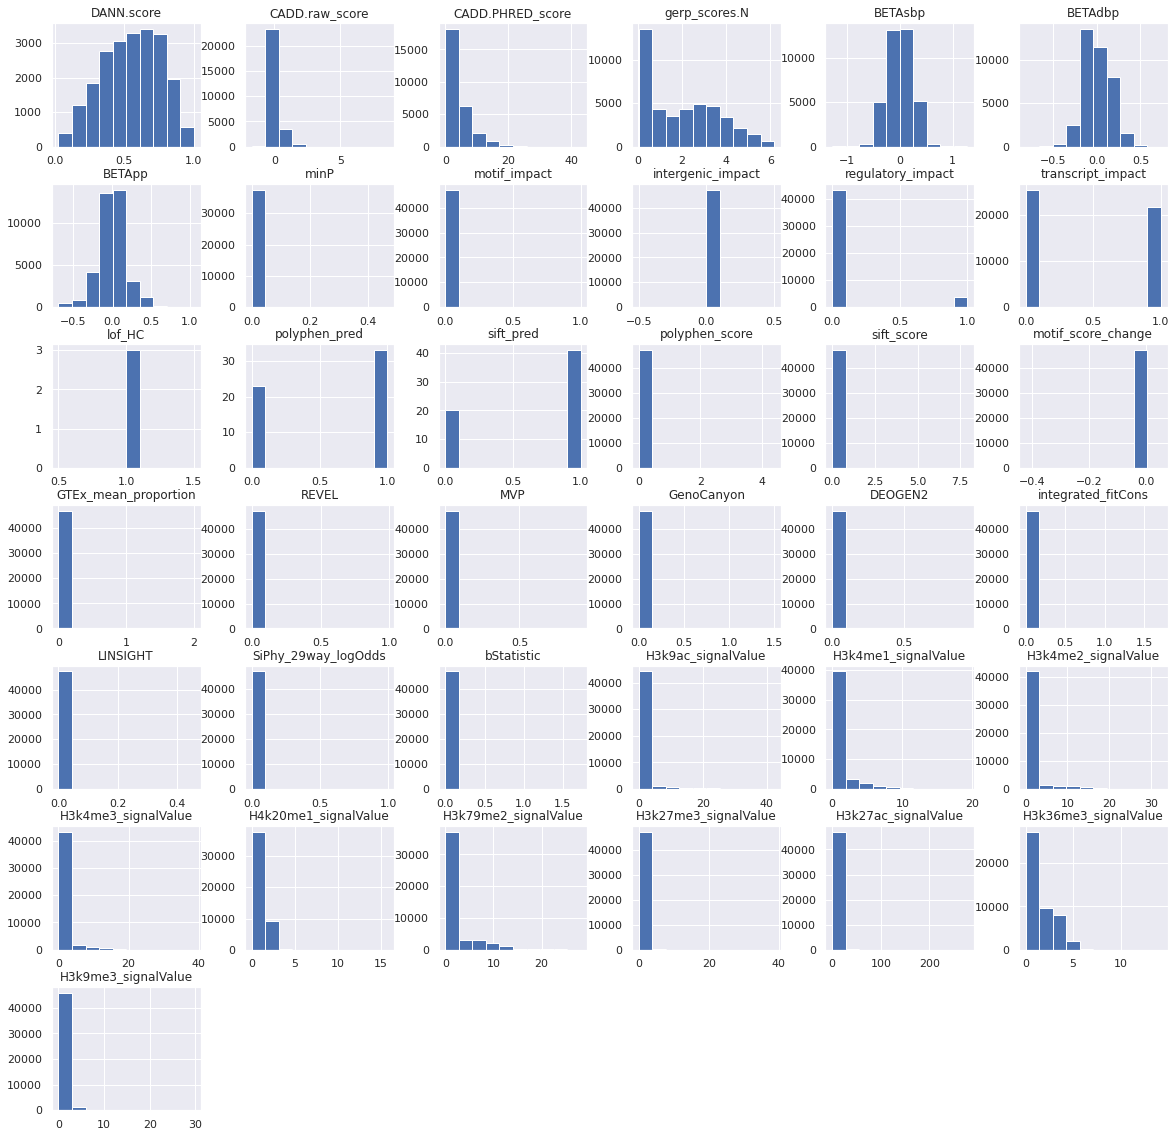

In [50]:
sns.set(style="darkgrid")
features.hist(figsize=(20,20))

In [68]:
positives = pd_table.loc[pd_table['label'] == True]
negatives = pd_table.loc[pd_table['label'] == False]
negatives = negatives.iloc[0:17,]
pos_neg_dt = positives.append(negatives)


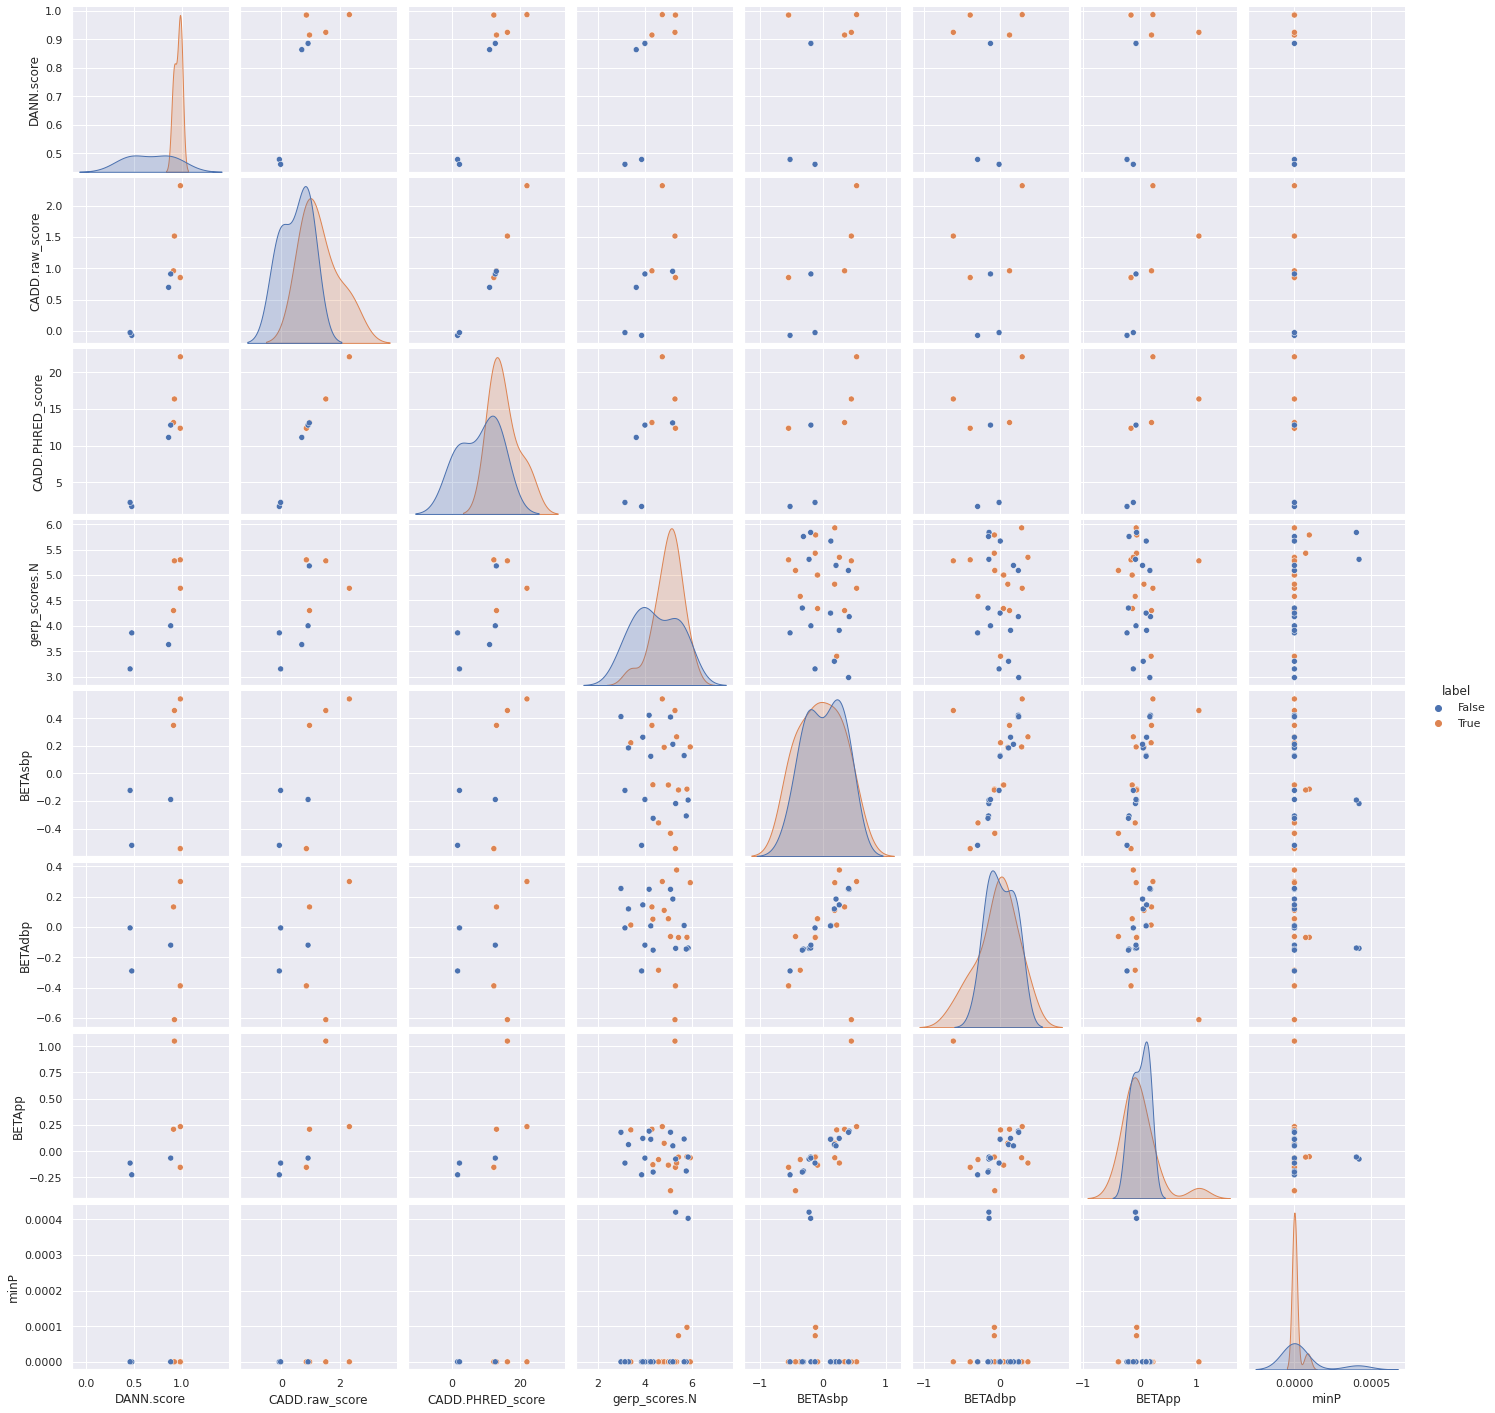

In [69]:
features2 = pos_neg_dt[[
 'label',
 'DANN.score',
 'CADD.raw_score',
 'CADD.PHRED_score',
 'gerp_scores.N',
 #'gerp_scores.S',
'BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
]]
sns.pairplot(features2, hue="label")

In [70]:
h1 = pos_neg_dt[[
    'label',
    'H3k9ac_signalValue']]

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k9ac_signalValue, dtype: object

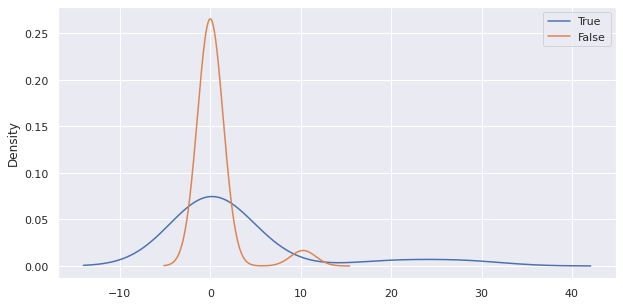

In [71]:
pos_neg_dt.groupby(pd.Grouper('label'))['H3k9ac_signalValue'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k4me2_signalValue, dtype: object

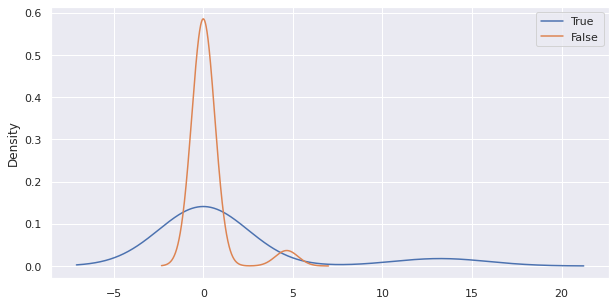

In [73]:
pos_neg_dt.groupby(pd.Grouper('label'))['H3k4me2_signalValue'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k4me3_signalValue, dtype: object

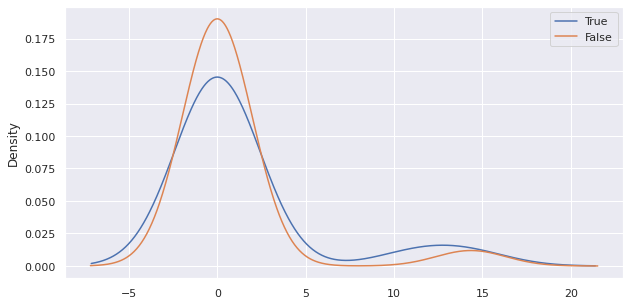

In [75]:
pos_neg_dt.groupby(pd.Grouper('label'))['H3k4me3_signalValue'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H4k20me1_signalValue, dtype: object

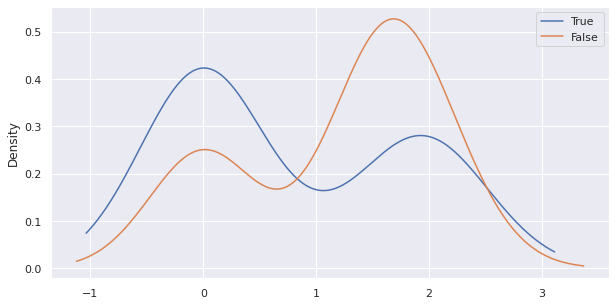

In [76]:
pos_neg_dt.groupby(pd.Grouper('label'))['H4k20me1_signalValue'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k79me2_signalValue, dtype: object

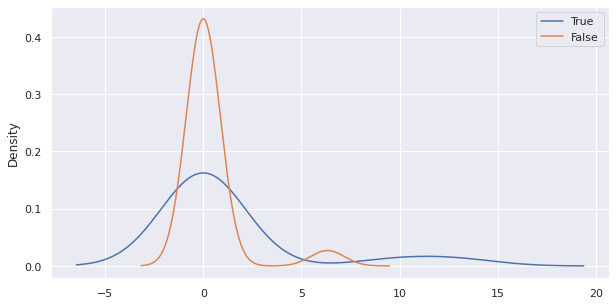

In [77]:
pos_neg_dt.groupby(pd.Grouper('label'))['H3k79me2_signalValue'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k27me3_signalValue, dtype: object

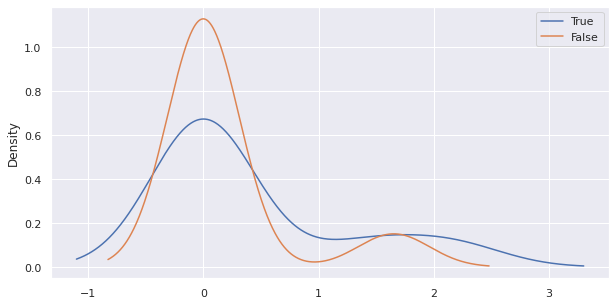

In [78]:
pos_neg_dt.groupby(pd.Grouper('label'))['H3k27me3_signalValue'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k36me3_signalValue, dtype: object

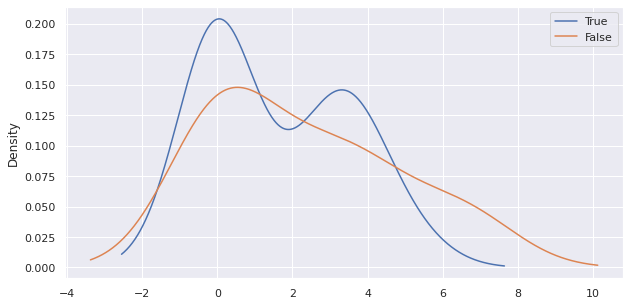

In [79]:
pos_neg_dt.groupby(pd.Grouper('label'))['H3k36me3_signalValue'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: H3k9me3_signalValue, dtype: object

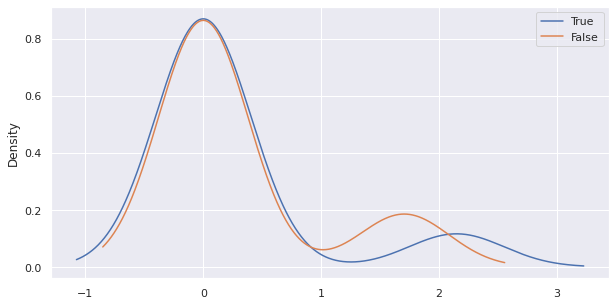

In [80]:
pos_neg_dt.groupby(pd.Grouper('label'))['H3k9me3_signalValue'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: DANN.score, dtype: object

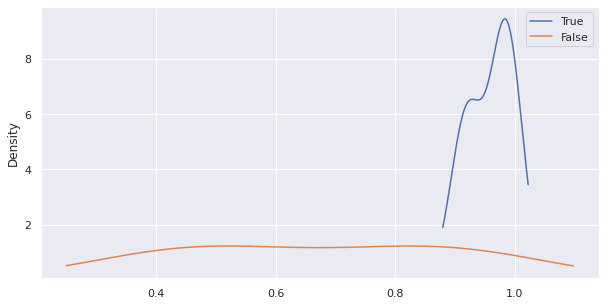

In [81]:
pos_neg_dt.groupby(pd.Grouper('label'))['DANN.score'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: CADD.raw_score, dtype: object

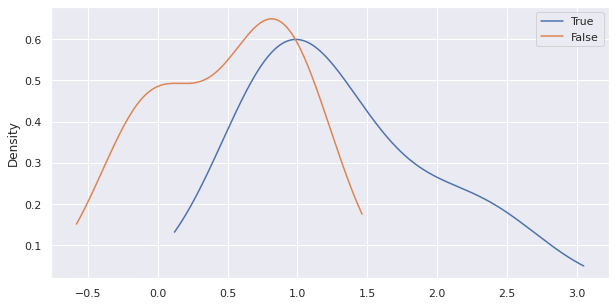

In [82]:
pos_neg_dt.groupby(pd.Grouper('label'))['CADD.raw_score'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: CADD.PHRED_score, dtype: object

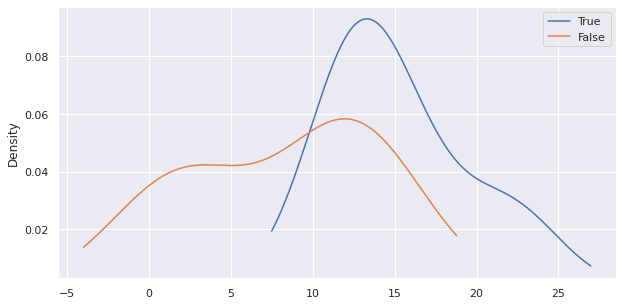

In [83]:
pos_neg_dt.groupby(pd.Grouper('label'))['CADD.PHRED_score'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: gerp_scores.N, dtype: object

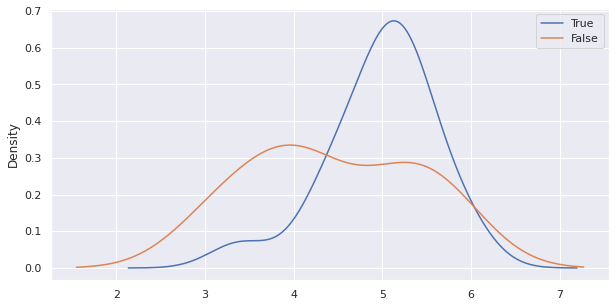

In [84]:
pos_neg_dt.groupby(pd.Grouper('label'))['gerp_scores.N'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: BETAsbp, dtype: object

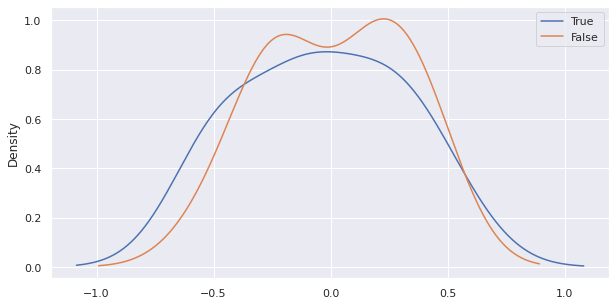

In [85]:
pos_neg_dt.groupby(pd.Grouper('label'))['BETAsbp'].plot(kind='density', legend=True, figsize=(10,5))

label
True     AxesSubplot(0.125,0.125;0.775x0.755)
False    AxesSubplot(0.125,0.125;0.775x0.755)
Name: minP, dtype: object

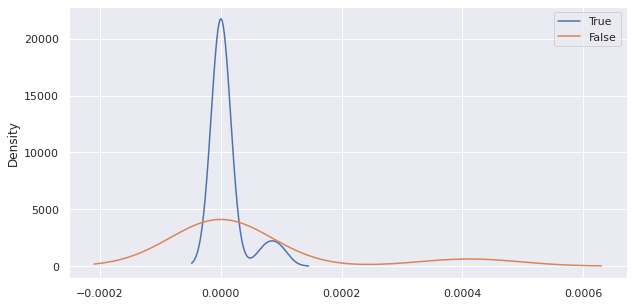

In [86]:
pos_neg_dt.groupby(pd.Grouper('label'))['minP'].plot(kind='density', legend=True, figsize=(10,5))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


label                   1.000000
polyphen_pred           0.160666
polyphen_score          0.151699
REVEL                   0.114981
DEOGEN2                 0.105990
integrated_fitCons      0.084736
GenoCanyon              0.077297
sift_score              0.071822
SiPhy_29way_logOdds     0.063693
bStatistic              0.049553
CADD.raw_score          0.040667
GTEx_mean_proportion    0.039830
CADD.PHRED_score        0.039349
gerp_scores.N           0.036084
DANN.score              0.029637
H3k9ac_signalValue      0.010616
regulatory_impact       0.006439
H4k20me1_signalValue    0.004645
H3k4me3_signalValue     0.004489
H3k36me3_signalValue    0.003992
H3k27ac_signalValue     0.003899
H3k4me2_signalValue     0.002102
motif_score_change      0.000297
H3k27me3_signalValue    0.000172
LINSIGHT               -0.000192
MVP                    -0.000195
BETApp                 -0.000302
motif_impact           -0.000516
minP                   -0.001046
H3k79me2_signalValue   -0.002465
H3k9me3_si

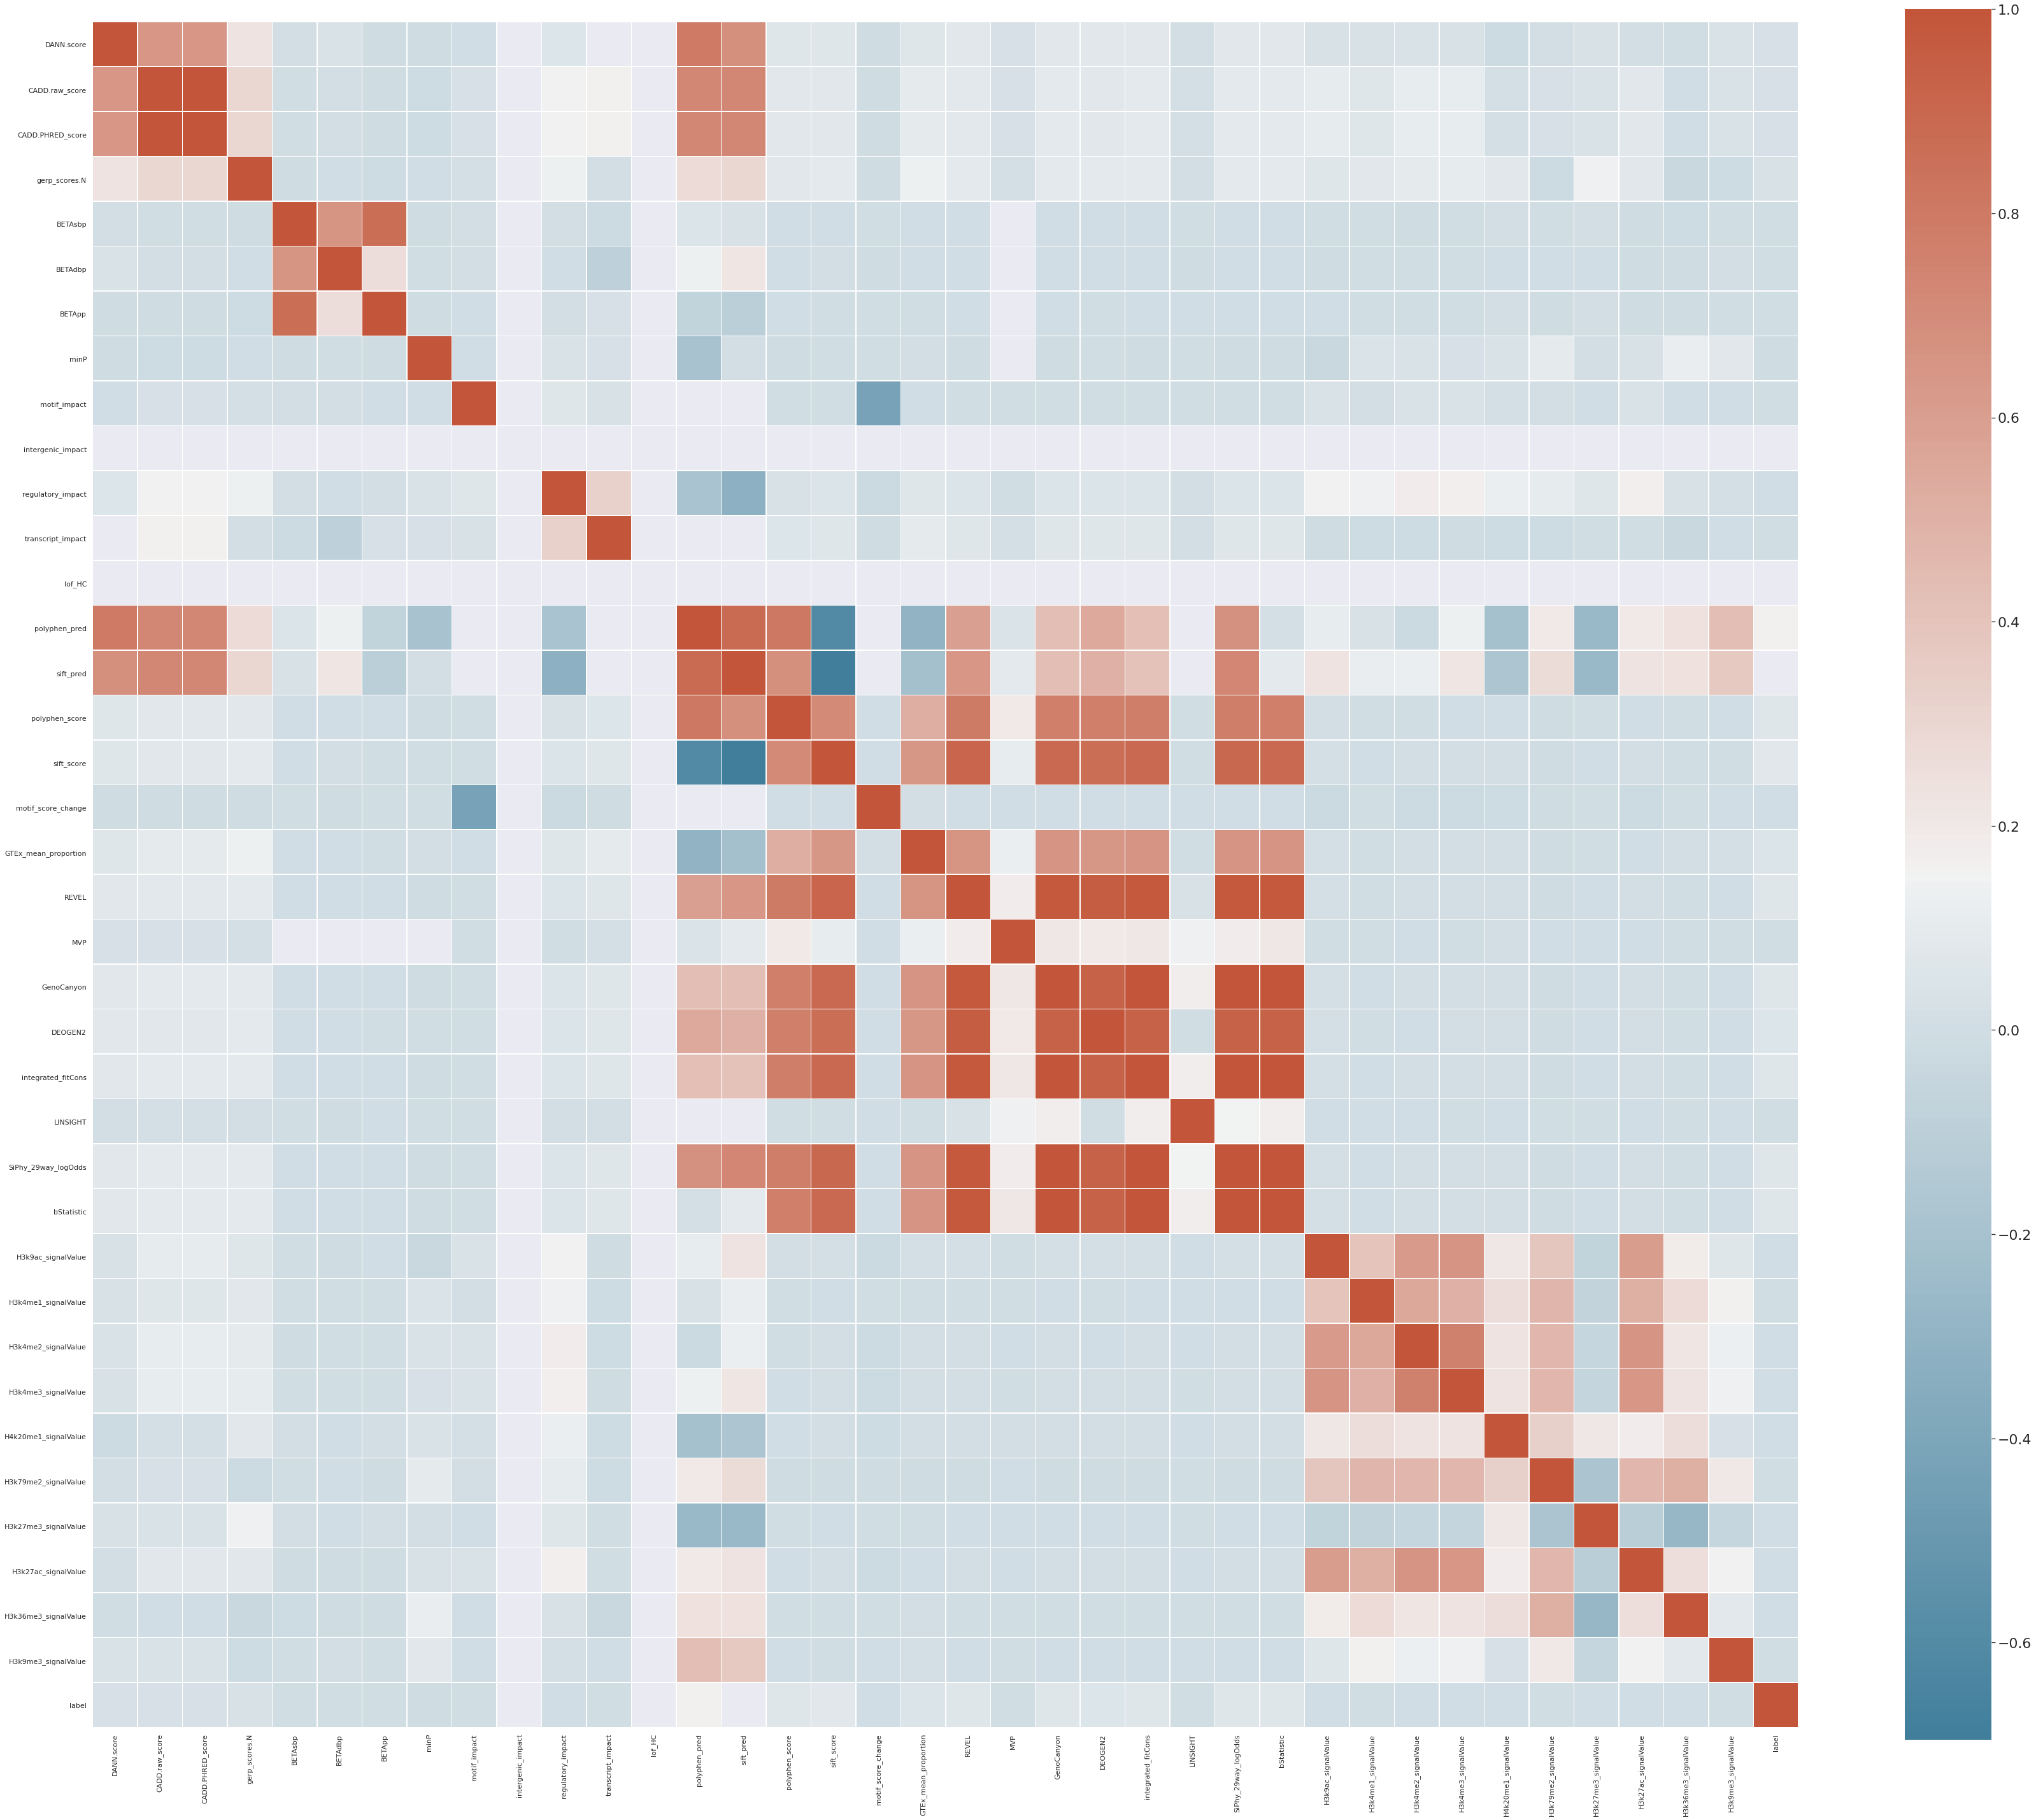

In [89]:
features['label'] = np.where(pd_table['label'] == True, 1, 0)
Xcor = features
corr = Xcor.corr(method="spearman")

f, ax = pyplot.subplots(figsize=(60, 50))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale = 2)
sns.heatmap(
    corr,
    cmap=cmap,
    square=True,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    ax=ax,
)

corr_matrix = features.corr()
print(corr_matrix["label"].sort_values(ascending=False))
corr = corr_matrix["label"].sort_values(ascending=False)

In [90]:
features['label'] = np.where(pd_table['label'] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [91]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [92]:
print(correlated_features)

{'sift_pred', 'BETApp', 'CADD.PHRED_score'}


In [95]:
pd_table['Y'] = np.where(pd_table['label'] == True, 1, 0)
Y = pd_table['Y']
X = pd_table.drop(['label', 'Gene', 'diagnosis', 'star', 'pathogenicity'
                   ], axis=1)

X.drop(labels=correlated_features, axis=1, inplace=True)
imputer = SimpleImputer(strategy='median', missing_values=np.nan)
X = X.set_index('CP')
X = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)

In [96]:
data_P = X[X.Y == 1]
data_P_test = data_P.sample(frac=0.2)

df_both = data_P.append(data_P_test)
data_P = df_both.drop_duplicates(keep=False)

data_U = X[X.Y == 0]
data_U_test = data_U.sample(207)

df_both = data_U.append(data_U_test)
data_U = df_both.drop_duplicates(keep=False)

df_test = data_P_test.append(data_U_test)

data_P_train = data_P
data_P = data_P.drop(['Y'], axis=1)
data_U = data_U.drop(['Y'], axis=1)

NP = data_P.shape[0]
NU = data_U.shape[0]

In [97]:
T = 1
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

Model fitting seconds: 0.07371306419372559


invalid value encountered in true_divide


In [ ]:
data_pos = data_P_train
y_pos = data_pos['Y']
data_pos = data_pos.drop(['Y'], axis=1)

y_pred_pos = model.predict_proba(data_pos)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]
y_pos = list(y_pos)

print('LightGBM Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0)) 

In [143]:
data_P_test_true = data_P_test.drop(['Y'], axis=1)

y_pos = data_P_test['Y']
y_pos = list(y_pos)

y_pred_pos = model.predict_proba(data_P_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

LightGBM Classification Results:
Accuracy: 95.65%
F1 Score: 97.78%


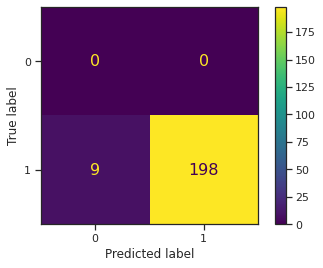

In [144]:
sns.set_style("ticks")
y_pos = data_P_test['Y']
cm = confusion_matrix(y_pos, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [145]:
df_test_true = df_test.drop(['Y'], axis=1)

y_true = df_test['Y']

y_pred_pos = model.predict_proba(df_test_true)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]


print('LightGBM Classification Results:')
acc = accuracy_score(y_true, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_true, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0))

LightGBM Classification Results:
Accuracy: 95.17%
F1 Score: 95.19%


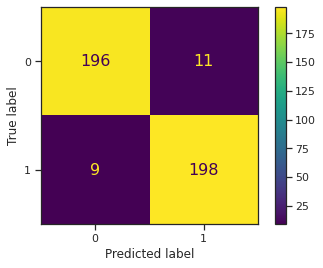

In [146]:
cm = confusion_matrix(y_true, y_predict_pos)

cm_display = ConfusionMatrixDisplay(cm).plot()

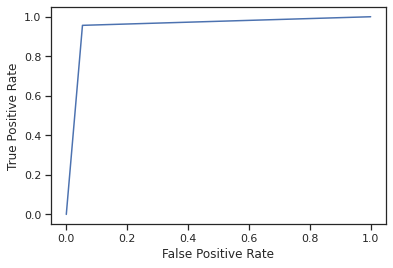

In [148]:
fpr, tpr, _ = roc_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

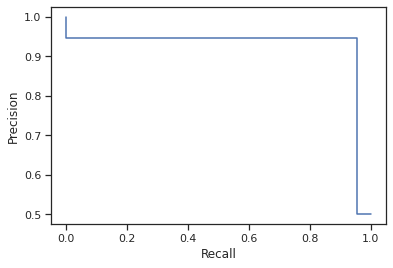

In [149]:
prec, recall, _ = precision_recall_curve(y_true, y_predict_pos, pos_label=model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


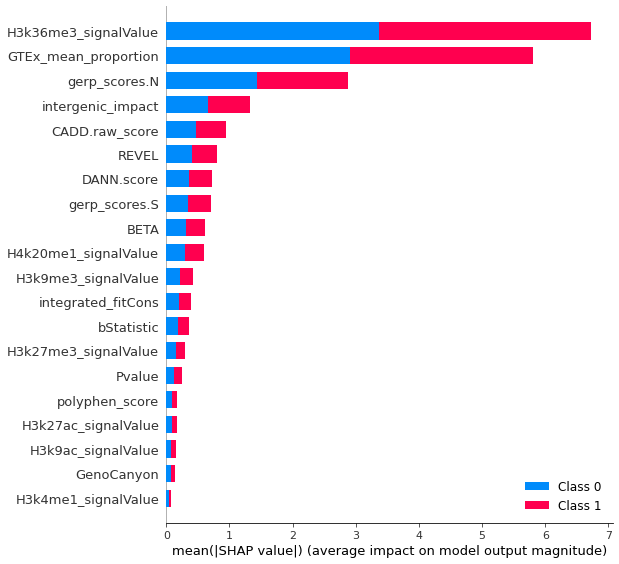

In [56]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(data_P_test_true) 
shap.summary_plot(shap_values, data_P_test_true) 

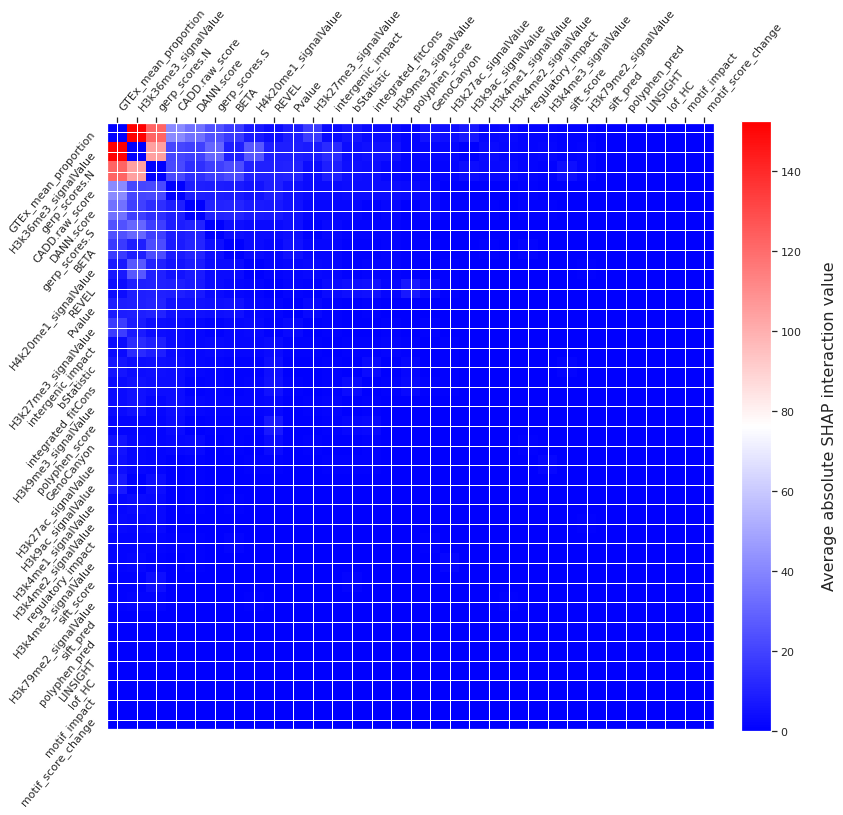

In [77]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(data_P_test_true)

expected_value = explainer.expected_value

tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]

sns.set(font_scale = 1)
f = pyplot.figure(figsize=(12, 12))
pyplot.imshow(
    tmp2, cmap="bwr"
)  # https://matplotlib.org/stable/gallery/color/colormap_reference.html
pyplot.yticks(
    range(tmp2.shape[0]),
    X_pos.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
pyplot.xticks(
    range(tmp2.shape[0]),
    X_pos.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
pyplot.gca().xaxis.tick_top()
cbar = pyplot.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
pyplot.rcParams.update({"font.size": 16})
pyplot.tight_layout()

In [63]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = data_P_test_true.iloc[select]
features_display = data_P_test_true.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-0.06850046]


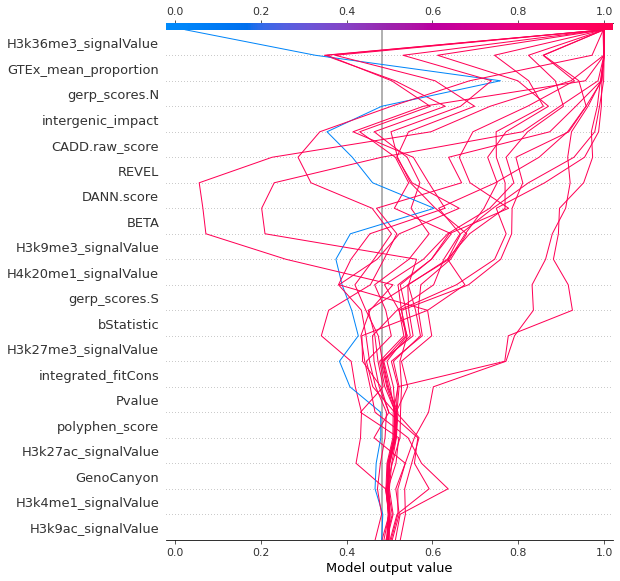

In [65]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

In [77]:
T = 10
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
start = time.time()
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U.iloc[bootstrap_sample, :]), axis=0)
    # Train model
    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
    
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U.iloc[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

end = time.time()
print('Model fitting seconds:', (end - start))

df = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)
#df['Y'] = X[X.Y == 1]
X_pos = X[X.Y == 1]
y_pos = X_pos['Y']
X_pos = X_pos.drop(['Y'], axis=1)

y_pred_pos = model.predict_proba(X_pos)
y_pred_pos = y_pred_pos[:,1]
y_predict_pos = [1 if x > 0.5 else 0 for x in y_pred_pos]
y_pos = list(y_pos)

print('XGBoost Classification Results:')
acc = accuracy_score(y_pos, y_predict_pos)
print("Accuracy: %.2f%%" % (acc * 100.0)) 
f1 = f1_score(y_pos, y_predict_pos)
print("F1 Score: %.2f%%" % (f1 * 100.0)) 

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Model fitting seconds: 20.235846519470215
XGBoost Classification Results:
Accuracy: 100.00%
F1 Score: 100.00%


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


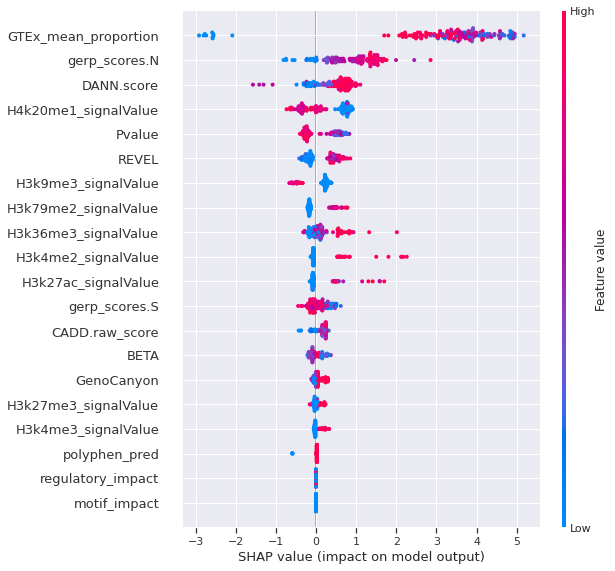

In [78]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X_pos) 
shap.summary_plot(shap_values, X_pos) 